# Hypothesis - "High Priority tasks take a longer time to complete"

In [14]:
import pandas as pd
import os
import glob
import tables
import numpy as np
import scipy as scp
from scipy import stats
import gc
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [12, 8]

***
## Loading data and Preprocessing

Preprocessing steps :
1. Removing data with Time stamp = 0
- Converting TimeStamp and Time taken fields to minutes
- Removing outliers

In [15]:
features = pd.read_hdf('features.h5')

In [16]:
features = features[features['time_taken']>=0]

In [17]:
features['time_taken'] = features['time_taken']/60
features['timestamp'] = features['timestamp']/(1000000*60)

In [18]:
q3, q1 = np.percentile(features.time_taken, [75, 25])

IQR = q3-q1

min_time = q1 - (IQR*1.5)
max_time = q3 + (IQR*1.5)

In [19]:
features = features[(features["time_taken"]>min_time) & (features["time_taken"]<max_time)]

In [20]:
features.head()

timestamp  priority   cpu_req   ram_req  disk_space_req  different_machine  \
0  10.067438         9  0.062500  0.015900    3.815000e-06                0.0   
1  10.202361         0  0.062500  0.004662    7.629000e-06                0.0   
2  10.285257         1  0.031250  0.015900    3.815000e-05                0.0   
3  10.323273         2  0.006248  0.001554    9.537000e-07                0.0   
4  10.553567         2  0.006248  0.003109    9.537000e-06                0.0   

       task_key  time_taken  
0  6251639646-0    1.186757  
1  6251668759-0    0.835414  
2  6251668917-0    0.602820  
3  6251668761-0    0.493892  
4  6251668915-0    0.910804

***
## Separating High and low priority tasks

In [21]:
threshold = 5
high_priority_tasks = features[features['priority']>threshold]
low_priority_tasks = features[features['priority']<=threshold]

In [22]:
high_priority_tasks.shape

(148800, 8)

In [23]:
low_priority_tasks.shape

(5651246, 8)

In [24]:
low_priority_tasks['time_taken'].describe()

count    5.651246e+06
mean     9.561353e+00
std      9.128117e+00
min      1.666667e-08
25%      2.945122e+00
50%      5.706275e+00
75%      1.341617e+01
max      4.070533e+01
Name: time_taken, dtype: float64

In [25]:
high_priority_tasks['time_taken'].describe()

count    148800.000000
mean          5.452128
std           6.387127
min           0.166630
25%           1.486872
50%           2.989193
75%           7.422592
max          40.702024
Name: time_taken, dtype: float64

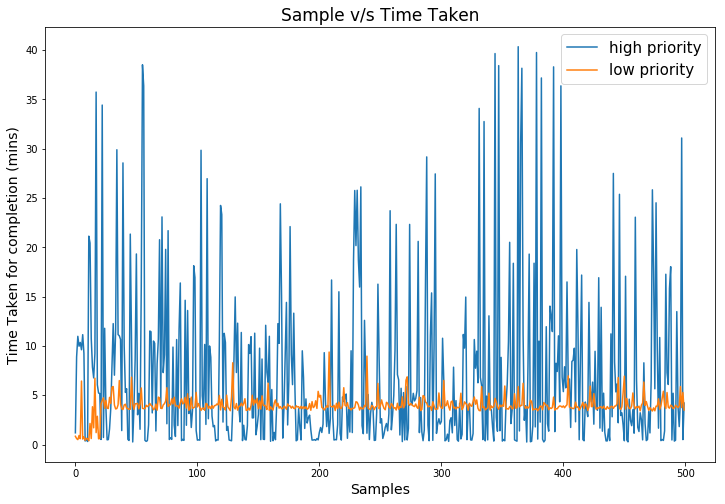

In [26]:
samples = 500
plt.title("Sample v/s Time Taken", fontsize=17)
plt.xlabel("Samples", fontsize=14)
plt.ylabel("Time Taken for completion (mins)", fontsize=14)
plt.plot(np.arange(samples), high_priority_tasks['time_taken'][:samples], label='high priority')
plt.plot(np.arange(samples), low_priority_tasks['time_taken'][:samples], label='low priority')
plt.legend(fontsize=15)

***
## Plotting Histograms and cdfs

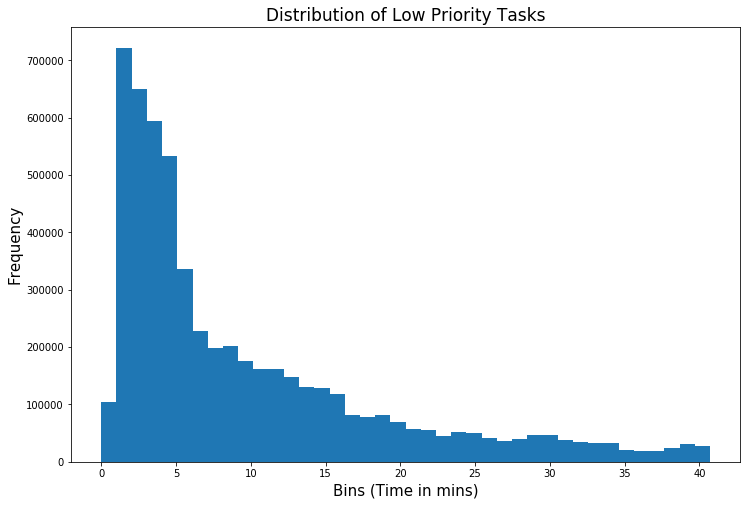

In [27]:
plt.title("Distribution of Low Priority Tasks", fontsize=17)
plt.xlabel("Bins (Time in mins)", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
count, bins, _ = plt.hist(low_priority_tasks['time_taken'], bins=40)

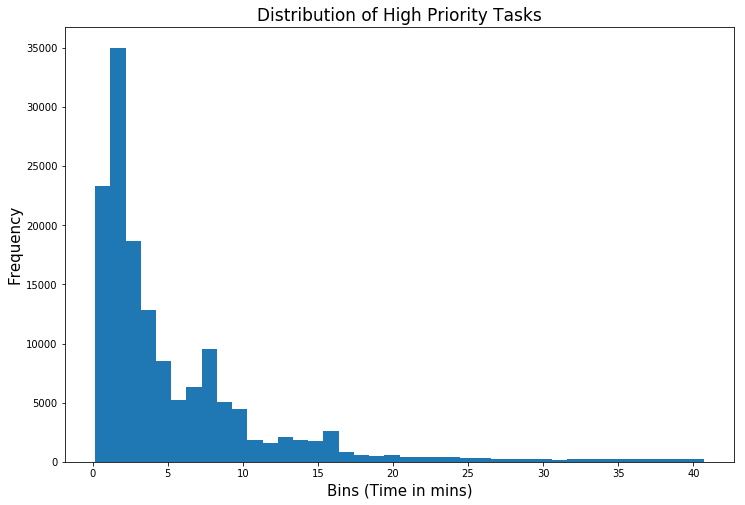

In [28]:
plt.title("Distribution of High Priority Tasks", fontsize=17)
plt.xlabel("Bins (Time in mins)", fontsize=15)
plt.ylabel("Frequency", fontsize=15)
count, bins, _ = plt.hist(high_priority_tasks['time_taken'], bins=40)

In [29]:
def cumfreq(a, num_bins=10, defaultreallimits=None, name=""):
    counts, bin_edges = np.histogram(a, bins=num_bins, normed=True)
    cdf = np.cumsum(counts)
    plt.title(name, fontsize=17)
    plt.plot(bin_edges[1:], cdf)

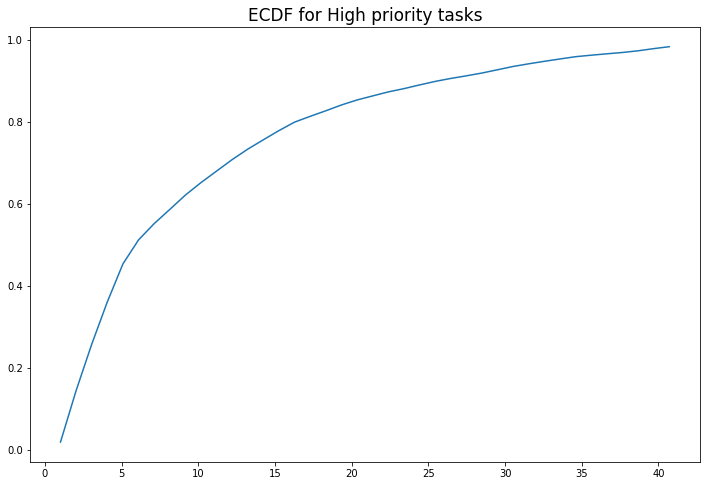

In [30]:
cumfreq(low_priority_tasks['time_taken'], num_bins=40, name="ECDF for High priority tasks")

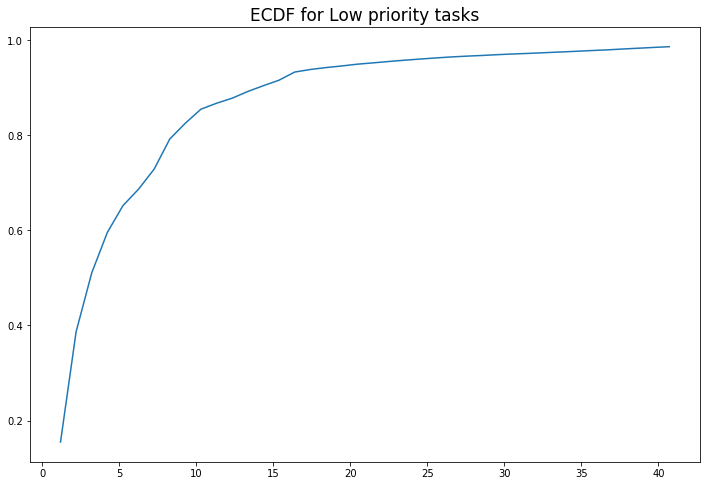

In [31]:
cumfreq(high_priority_tasks['time_taken'], num_bins=40, name="ECDF for Low priority tasks")

***
## Normality of the original data

In [32]:
n = features['time_taken'].shape[0]
print("n = ", n)

n =  5800046


Referring to http://www.real-statistics.com/statistics-tables/kolmogorov-smirnov-table/ 

for finding the critical value of D

In [33]:
D_max = 1.51743/np.sqrt(n)
print('D_max = ', D_max)

D_max =  0.0006300760138999607


In [34]:
ks_results = stats.kstest(features['time_taken'], cdf='norm')

# matrix_ks = [
#     ['', 'DF', 'Test Statistic', 'p-value'],
#     ['Sample Data', features['time_taken'].shape[0] - 1, ks_results[0], ks_results[1]]
# ]

print(ks_results)
# ks_table = FF.create_table(matrix_ks, index=True)
# py.iplot(ks_table, filename='ks-table')

if ks_results[0] < D_max:
    print('Since, {} < {}, Accept Null'.format(ks_results[0], D_max))
else:
    print('Since, {} > {}, Reject Null'.format(ks_results[0], D_max))


KstestResult(statistic=0.8538332638798539, pvalue=0.0)
Since, 0.8538332638798539 > 0.0006300760138999607, Reject Null


### Hence, we cannot apply T-test directly
***

In [35]:
# popmean = low_priority_tasks['time_taken'].mean()
# stats.ttest_1samp(high_priority_tasks['time_taken'], 0.16*popmean)

In [36]:

# exp = 10*stats.expon.rvs(size=n, loc=high_priority_tasks['time_taken'].mean())
# ks_results = stats.ks_2samp(high_priority_tasks['time_taken'], exp)
# ks_results

## Asymptotic Normality

Taking mean over chunks of data, to use asymptotic normality for further analysis

In [60]:
hp_time_taken_mean = high_priority_tasks.groupby(np.arange(len(high_priority_tasks))//148.8)['time_taken'].mean()
lp_time_taken_mean = low_priority_tasks.groupby(np.arange(len(low_priority_tasks))//2500)['time_taken'].mean()

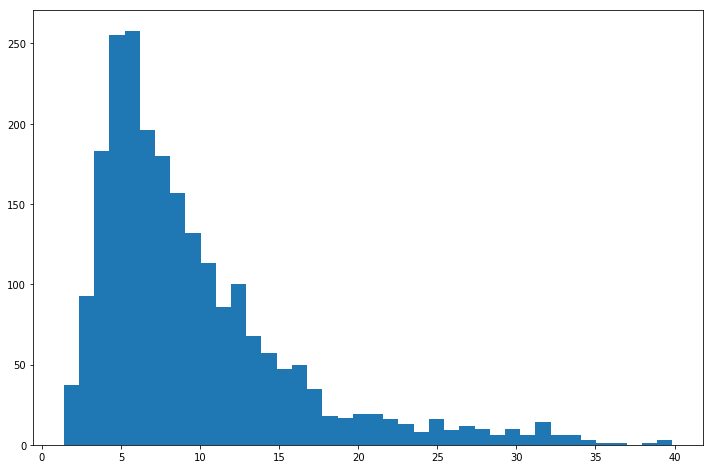

In [61]:
count, bins, _ = plt.hist(lp_time_taken_mean, bins=40)

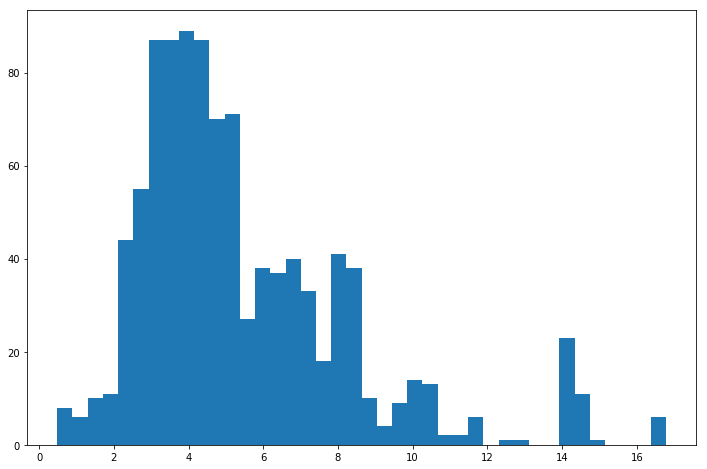

In [62]:
count, bins, _ = plt.hist(hp_time_taken_mean, bins=40)

In [63]:

n = hp_time_taken_mean.shape[0]
h = lp_time_taken_mean.shape[0]
# print(high_priority_tasks.shape[0]/100)
print(n, h)
if n > 50:
    D_max = 1.51743/np.sqrt(n)
else:
    print("Search for the proper value")
    D_max = 0.45662 # n = 10
    D_max = 0.68887 # n = 4

1000 2261


## KS-test

In [64]:
ks_results = stats.kstest(hp_time_taken_mean, cdf='norm')

print(ks_results)

if ks_results[0] < D_max:
    print('Since, {} < {}, Accept Null'.format(ks_results[0], D_max))
else:
    print('Since, {} > {}, Reject Null'.format(ks_results[0], D_max))


KstestResult(statistic=0.9492226293998979, pvalue=0.0)
Since, 0.9492226293998979 > 0.04798534989869304, Reject Null


## T-test
**df** = 1000

**alpha** = 0.025

**t_crit** = 1.962

In [66]:
popmean = low_priority_tasks['time_taken'].mean()
stats.ttest_1samp(hp_time_taken_mean, 0.5*popmean)

Ttest_1sampResult(statistic=7.346153927644449, pvalue=4.23159383800146e-13)

### Since, t-statistic value is greater than 1.962 
### Hence, we reject the Null hypothesis